In [59]:
from sklearn.preprocessing import LabelEncoder
!pip install lightgbm
import matplotlib.pyplot as plt

In [60]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import root_mean_squared_error
import pandas as pd


In [54]:
training_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/notebooks/final_train_data.csv')
testing_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/notebooks/final_test_data.csv')



In [61]:
print(training_data.columns)
featured_training_data = training_data[['store_nbr', 'family', 'onpromotion', 'transactions', 'city', 'state',
    'type', 'cluster', 'dcoilwtico', 'is_holiday', 'dayofweek', 'day', 'month',
    'year', 'weekofyear', 'is_weekend', 'lag_1', 'lag_7', 'rolling_mean_7',
    'rolling_std_7', 'rolling_mean_30', 'stockout']]
featured_testing_data = testing_data[['store_nbr', 'family', 'onpromotion', 'transactions', 'city', 'state',
    'type', 'cluster', 'dcoilwtico', 'is_holiday', 'dayofweek', 'day', 'month',
    'year', 'weekofyear', 'is_weekend', 'lag_1', 'lag_7', 'rolling_mean_7',
    'rolling_std_7', 'rolling_mean_30', 'stockout']]
testing_data_copy = featured_testing_data.copy()
target_data_train = training_data[['log_sales']]
target_data_test = testing_data[['log_sales']]

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'log_sales', 'transactions', 'city', 'state', 'type', 'cluster',
       'dcoilwtico', 'is_holiday', 'dayofweek', 'day', 'month', 'year',
       'weekofyear', 'is_weekend', 'lag_1', 'lag_7', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_30', 'stockout'],
      dtype='object')


In [62]:
featured_training_data
target_data_train

,log_sales
0,0.000000
1,1.098612
2,1.386294
3,1.386294
4,1.791759
...,...
2409259,0.000000
2409260,0.000000
2409261,0.000000
2409262,0.000000


In [63]:
categorical_columns = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster']
label_encoder = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    featured_training_data[col] = encoder.fit_transform(featured_training_data[col])
    featured_testing_data[col] = encoder.fit_transform(featured_testing_data[col])

/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/3325468299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_training_data[col] = encoder.fit_transform(featured_training_data[col])
/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/3325468299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_testing_data[col] = encoder.fit_transform(featured_testing_data[col])
/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/3325468299.py:5: SettingWithCop

In [64]:
from lightgbm import early_stopping, log_evaluation
training_set = lgb.Dataset(featured_training_data, label=target_data_train)
testing_set = lgb.Dataset(featured_testing_data, label=target_data_test)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 128,           # try 31, 64, 128
    'max_depth': 10,             # try 5–10
    'learning_rate': 0.01,      # lower for better generalization
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.8
}
model = lgb.train(params, train_set=training_set, valid_sets=[training_set, testing_set], num_boost_round=5000, callbacks=[early_stopping(stopping_rounds=100),log_evaluation(period=100)])
prediction = model.predict(featured_testing_data)

rmse = root_mean_squared_error(target_data_test, prediction)
print("Test RMSE:", rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 2409264, number of used features: 22
[LightGBM] [Info] Start training from score 2.776644
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03915	valid_1's rmse: 1.04372
[200]	training's rmse: 0.48288	valid_1's rmse: 0.507483
[300]	training's rmse: 0.339475	valid_1's rmse: 0.375354
[400]	training's rmse: 0.310456	valid_1's rmse: 0.3504
[500]	training's rmse: 0.30302	valid_1's rmse: 0.344698
[600]	training's rmse: 0.2994	valid_1's rmse: 0.342369
[700]	training's rmse: 0.29726	valid_1's rmse: 0.340992
[800]	training's rmse: 0.295527	valid_1's rmse: 0.339515
[900]	training's rmse: 0.29408	valid_1's rmse: 0.338397
[1000]	training's rmse: 0.2

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

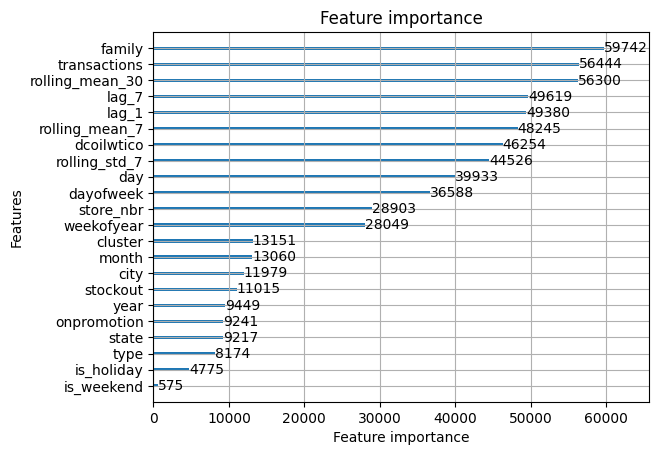

In [65]:
lgb.plot_importance(model, max_num_features=27)


In [66]:
testing_data_copy['prediction'] = prediction
testing_data_copy['target'] = target_data_test
print(target_data_test.shape)

mse_by_fam = testing_data_copy.groupby('family').apply(lambda x: root_mean_squared_error(x['target'], x['prediction']))

(591624, 1)


/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/792532565.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_fam = testing_data_copy.groupby('family').apply(lambda x: root_mean_squared_error(x['target'], x['prediction']))


In [ ]:
mse_by_fam

family
AUTOMOTIVE                    0.444109
BABY CARE                     0.125178
BEAUTY                        0.367013
BEVERAGES                     0.175617
BOOKS                         0.204854
BREAD/BAKERY                  0.160349
CELEBRATION                   0.495422
CLEANING                      0.210290
DAIRY                         0.152861
DELI                          0.175096
EGGS                          0.318644
FROZEN FOODS                  0.301631
GROCERY I                     0.159791
GROCERY II                    0.465895
HARDWARE                      0.293589
HOME AND KITCHEN I            0.492318
HOME AND KITCHEN II           0.404105
HOME APPLIANCES               0.152386
HOME CARE                     0.178312
LADIESWEAR                    0.385625
LAWN AND GARDEN               0.426926
LINGERIE                      0.485462
LIQUOR,WINE,BEER              0.520546
MAGAZINES                     0.377005
MEATS                         0.231831
PERSONAL CARE     

In [67]:
print(mse_by_fam.sort_values(ascending=False))


family
LIQUOR,WINE,BEER              0.520546
CELEBRATION                   0.495422
HOME AND KITCHEN I            0.492318
LINGERIE                      0.485462
GROCERY II                    0.465895
AUTOMOTIVE                    0.444109
LAWN AND GARDEN               0.426926
PLAYERS AND ELECTRONICS       0.408615
HOME AND KITCHEN II           0.404105
LADIESWEAR                    0.385625
SEAFOOD                       0.382122
MAGAZINES                     0.377005
BEAUTY                        0.367013
PET SUPPLIES                  0.360996
SCHOOL AND OFFICE SUPPLIES    0.341213
EGGS                          0.318644
FROZEN FOODS                  0.301631
HARDWARE                      0.293589
PREPARED FOODS                0.266693
MEATS                         0.231831
POULTRY                       0.221779
PERSONAL CARE                 0.213747
CLEANING                      0.210290
BOOKS                         0.204854
PRODUCE                       0.193598
HOME CARE         

In [68]:
unique_combos = training_data[['store_nbr', 'family']].drop_duplicates()

In [71]:
forecast_dates = pd.date_range(start='2017-08-16', end='2017-08-31')
future_predictions = pd.DataFrame([
    {'store_nbr': row['store_nbr'], 'family': row['family'], 'date': date}
    for _, row in unique_combos.iterrows()
    for date in forecast_dates
])
future_predictions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   store_nbr  28512 non-null  int64         
 1   family     28512 non-null  object        
 2   date       28512 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 668.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409264 entries, 0 to 2409263
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   date             object 
 2   store_nbr        int64  
 3   family           object 
 4   sales            float64
 5   onpromotion      int64  
 6   log_sales        float64
 7   transactions     float64
 8   city             object 
 9   state            object 
 10  type             object 
 11  cluster          int64  
 12  dcoilwtico       float64
 13  is_holiday       f

In [72]:
holidays_event_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/data/raw/holidays_events.csv')
oil_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/data/raw/oil.csv')
stores_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/data/raw/stores.csv')
transactions_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/data/raw/transactions.csv')
sample_submission_data = pd.read_csv('/Users/nsumesh/Documents/GitHub/ProductDemandForecasting/data/raw/sample_submission.csv')
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
holidays_event_data['date'] = pd.to_datetime(holidays_event_data['date'])
holidays_clean = holidays_event_data[
    (holidays_event_data['locale'] == 'National') & 
    (holidays_event_data['transferred'] == False)
]
holidays_clean = holidays_clean[['date']].drop_duplicates()
holidays_clean['is_holiday'] = 1
# future_predictions = future_predictions.merge(transactions_data, on=['store_nbr', 'date'], how='left')
# future_predictions = future_predictions.merge(oil_data, on='date', how='left')
# future_predictions = future_predictions.merge(holidays_event_data, on='date', how='left')
# future_predictions = future_predictions.merge(stores_data, on='store_nbr', how='left')

In [73]:
future_predictions = future_predictions.merge(transactions_data, on=['store_nbr', 'date'], how='left')
future_predictions = future_predictions.merge(oil_data, on='date', how='left')
future_predictions = future_predictions.merge(holidays_event_data, on='date', how='left')
future_predictions = future_predictions.merge(stores_data, on='store_nbr', how='left')


In [74]:
future_predictions['sales'] = np.nan

future_predictions.rename(columns={'type_y':'type'}, inplace=True)
future_predictions

,store_nbr,family,date,transactions,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type,cluster,sales
0,1,AUTOMOTIVE,2017-08-16,NaN,46.80,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
1,1,AUTOMOTIVE,2017-08-17,NaN,47.07,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
2,1,AUTOMOTIVE,2017-08-18,NaN,48.59,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
3,1,AUTOMOTIVE,2017-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
4,1,AUTOMOTIVE,2017-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,54,SEAFOOD,2017-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,El Carmen,Manabi,C,3,NaN
28508,54,SEAFOOD,2017-08-28,NaN,46.40,NaN,NaN,NaN,NaN,NaN,El Carmen,Manabi,C,3,NaN
28509,54,SEAFOOD,2017-08-29,NaN,46.46,NaN,NaN,NaN,NaN,NaN,El Carmen,Manabi,C,3,NaN
28510,54,SEAFOOD,2017-08-30,NaN,45.96,NaN,NaN,NaN,NaN,NaN,El Carmen,Manabi,C,3,NaN


In [75]:

training_data_copy = training_data.copy()
training_data_copy = pd.concat([training_data_copy, future_predictions], ignore_index=True)


In [76]:
training_data_copy

,id,date,store_nbr,family,sales,onpromotion,log_sales,transactions,city,state,...,lag_7,rolling_mean_7,rolling_std_7,rolling_mean_30,stockout,type_x,locale,locale_name,description,transferred
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.000000,NaN,Quito,Pichincha,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,1782.0,2013-01-02,1,AUTOMOTIVE,2.0,0.0,1.098612,2111.0,Quito,Pichincha,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,3564.0,2013-01-03,1,AUTOMOTIVE,3.0,0.0,1.386294,1833.0,Quito,Pichincha,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,5346.0,2013-01-04,1,AUTOMOTIVE,3.0,0.0,1.386294,1863.0,Quito,Pichincha,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,7128.0,2013-01-05,1,AUTOMOTIVE,5.0,0.0,1.791759,1509.0,Quito,Pichincha,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437771,NaN,2017-08-27 00:00:00,54,SEAFOOD,NaN,NaN,NaN,NaN,El Carmen,Manabi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2437772,NaN,2017-08-28 00:00:00,54,SEAFOOD,NaN,NaN,NaN,NaN,El Carmen,Manabi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2437773,NaN,2017-08-29 00:00:00,54,SEAFOOD,NaN,NaN,NaN,NaN,El Carmen,Manabi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2437774,NaN,2017-08-30 00:00:00,54,SEAFOOD,NaN,NaN,NaN,NaN,El Carmen,Manabi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
training_data_copy = training_data_copy.sort_values(['store_nbr', 'family', 'date'])
training_data_copy['lag_1'] = training_data_copy.groupby(['store_nbr', 'family'])['sales'].shift(1)
training_data_copy['lag_7'] = training_data_copy.groupby(['store_nbr', 'family'])['sales'].shift(7)

training_data_copy['rolling_mean_7'] = training_data_copy.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean().reset_index(0, drop=True)
training_data_copy['rolling_std_7'] = training_data_copy.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).std().reset_index(0, drop=True)

training_data_copy['rolling_mean_30'] = training_data_copy.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(30).mean().reset_index(0, drop=True)

In [78]:
training_data_copy['date'] = pd.to_datetime(training_data_copy['date'])
training_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2437776 entries, 2409264 to 2409263
Data columns (total 31 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               float64       
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   family           object        
 4   sales            float64       
 5   onpromotion      float64       
 6   log_sales        float64       
 7   transactions     float64       
 8   city             object        
 9   state            object        
 10  type             object        
 11  cluster          int64         
 12  dcoilwtico       float64       
 13  is_holiday       float64       
 14  dayofweek        float64       
 15  day              float64       
 16  month            float64       
 17  year             float64       
 18  weekofyear       float64       
 19  is_weekend       float64       
 20  lag_1            float64       
 21  lag_7            float64      

In [79]:

final_prediction_input = training_data_copy[training_data_copy['date'] >= '2017-08-16'].copy()



final_prediction_input['date'] = pd.to_datetime(final_prediction_input['date'])
final_prediction_input['dayofweek'] = final_prediction_input['date'].dt.dayofweek       
final_prediction_input['day'] = final_prediction_input['date'].dt.day
final_prediction_input['month'] = final_prediction_input['date'].dt.month
final_prediction_input['year'] = final_prediction_input['date'].dt.year
final_prediction_input['weekofyear'] = final_prediction_input['date'].dt.isocalendar().week.astype(int)
final_prediction_input['is_weekend'] = final_prediction_input['dayofweek'].isin([5, 6]).astype(int)

final_prediction_input.info()


<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 2409264 to 2437775
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               0 non-null      float64       
 1   date             28512 non-null  datetime64[ns]
 2   store_nbr        28512 non-null  int64         
 3   family           28512 non-null  object        
 4   sales            0 non-null      float64       
 5   onpromotion      0 non-null      float64       
 6   log_sales        0 non-null      float64       
 7   transactions     0 non-null      float64       
 8   city             28512 non-null  object        
 9   state            28512 non-null  object        
 10  type             28512 non-null  object        
 11  cluster          28512 non-null  int64         
 12  dcoilwtico       21384 non-null  float64       
 13  is_holiday       0 non-null      float64       
 14  dayofweek        28512 non-null  in

In [80]:
final_input = final_prediction_input[['store_nbr', 'family', 'onpromotion', 'transactions', 'city', 'state',
    'type', 'cluster', 'dcoilwtico', 'is_holiday', 'dayofweek', 'day', 'month',
    'year', 'weekofyear', 'is_weekend', 'lag_1', 'lag_7', 'rolling_mean_7',
    'rolling_std_7', 'rolling_mean_30', 'stockout']]

categorical_columns = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster']
label_encoder = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    final_input[col] = encoder.fit_transform(final_input[col])


/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/3663108232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input[col] = encoder.fit_transform(final_input[col])
/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/3663108232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input[col] = encoder.fit_transform(final_input[col])
/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/3663108232.py:10: SettingWithCopyWarning: 
A value is trying to be set 

In [82]:
final_input.to_csv('final_input.csv', index=False)

In [83]:
final_prediction = model.predict(final_input)


In [84]:
final_input['sales'] = np.expm1(final_prediction)
final_input['date'] = final_prediction_input['date']

final_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 2409264 to 2437775
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   store_nbr        28512 non-null  int64         
 1   family           28512 non-null  int64         
 2   onpromotion      0 non-null      float64       
 3   transactions     0 non-null      float64       
 4   city             28512 non-null  int64         
 5   state            28512 non-null  int64         
 6   type             28512 non-null  int64         
 7   cluster          28512 non-null  int64         
 8   dcoilwtico       21384 non-null  float64       
 9   is_holiday       0 non-null      float64       
 10  dayofweek        28512 non-null  int32         
 11  day              28512 non-null  int32         
 12  month            28512 non-null  int32         
 13  year             28512 non-null  int32         
 14  weekofyear       28512 non-null  in

/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/2320292655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input['sales'] = np.expm1(final_prediction)
/var/folders/g0/v1wjk0gd60vfzpkkvq50mpmh0000gn/T/ipykernel_25395/2320292655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input['date'] = final_prediction_input['date']


In [122]:
final_prediction_input['sales'] = np.expm1(final_prediction)
daily_forecast_by_store_family = final_prediction_input[['store_nbr','family','date','sales']]
agg_per_store = final_prediction_input.groupby(['store_nbr'])['sales'].sum().reset_index()
agg_per_store_family = final_prediction_input.groupby(['store_nbr','family'])['sales'].sum().reset_index()
agg_date = final_prediction_input.groupby(['date'])['sales'].sum().reset_index()


In [123]:
daily_forecast_by_store_family.to_csv('daily_forecast_by_store_family.csv', index=False)
agg_per_store.to_csv('agg_per_store.csv', index=False)
agg_per_store_family.to_csv('agg_per_store_family.csv', index=False)
agg_date.to_csv('agg_date.csv', index=False)